# Introduction

In this notebook, we will implement the spectral graph clustering algorithm as described in the [paper](http://ai.stanford.edu/~ang/papers/nips01-spectral.pdf) “<i>On Spectral Clustering: Analysis and an algorithm</i>” by Andrew Y. Ng, Michael I. Jordan and Yair Weiss.

### Environment

We will implement the algorithm in MATLAB, since it can be easily written in few lines of code. This Jupyter Notebook contains the self-explanation code of this project thanks to [this](https://github.com/imatlab/imatlab) really cool Jupyter kernel for MATLAB.

# Dataset 1

The [first](http://moreno.ss.uci.edu/data.html#ckm) dataset is a real graph collected by Coleman, Katz and Menzel on medical innovation in 1966. The data comes from physicians in four towns in Illinois, Peoria, Bloomington, Quincy and Galesburg:

In [1]:
% For reproducibility
rng(999)

% DATASET 1
E = csvread('./data/example1.dat');
k = 4;
maxIter = 1000;

# Algorithm

Spectral clustering algorithms attempt to cluster points into $k$ different groups using the top eigenvectors of a matrix derived from the distance between points. Concretely, spectral graph algorithm defines this distance by building a weighted graph where nodes correspond to datapoints and edges are related to the distance between points. We define the `spectra` method which receives the following parameters:

* `E`: edge list
* `k`: number of clusters
* `maxIter`: maximum number of iterations for the cluster algorithm (usually $k$-means)

We will use how the algorithm works using this dataset. First, we create the adjacency matrix of the graph which will be the affinity matrix $A$ in this problem. If we would have datapoints in the space, we would define $A \in \mathbb{R}^{n \times n}$ as $A_{ij} = exp(-||s_i - s_j||^2/2\sigma^2)$ if $i \not = j$, and $A_{ii} = 0$:

In [2]:
% Converting Edge list to adjacency matrix
col1 = E(:,1);
col2 = E(:,2);
max_ids = max(max(col1,col2));
As = sparse(col1, col2, 1, max_ids, max_ids); 
A = full(As);

Second, we define $D$ be the diagonal matrix matrix whose $(i,i)$-element is the sum of $A$'s $i$-th row, and construct the matrix $L = D^{-1/2}AD^{-1/2}$:

In [3]:
D = diag(sum(A, 2));
L = D^(-1/2)*A*D^(-1/2);

Third, we find the $k$ largest eigenvectors of $L$ and form the matrix $X$:

In [4]:
[X, ~] = eigs(L, k, 'LA'); %LA means largest real

Fourth, we form the matrix $Y$ from $X$ by renormalizing each of $X$'s rows to have unit length:

In [5]:
Y = bsxfun(@rdivide, X, sum(X.^2, 2).^(1/2));

Then, we treat each row of $Y$ as a point in $\mathbb{R}^k$, and cluster them into $k$ clusters using the $k$-means algorithm:


In [6]:
idx = kmeans(Y, k, 'MaxIter', maxIter);

We build the graph from the adjacency matrix and mark each node according to the cluster it was assigned by the algorithm:

In [7]:
G = graph(full(As));
G.Nodes.cluster = idx;

Before plotting the clusters, we use an auxiliary function called `colorSpectrum` which creates a spectrum of $N$ colors from red to green to blue:

In [8]:
N = k;
R = linspace(255,-255,N)';
P = [linspace(0,255,ceil(N/2)),linspace(255,0,ceil(N/2))]';
if mod(N,2)
    P = [P(1:ceil(N/2));P(ceil(N/2)+2:end)];
end
B = linspace(-255,255,N)';
ColorCodes = [R,P,B]/255;
ColorCodes = max(0,ColorCodes);

Finally, we convert each cluster label from indexes to $k$ different colors using the last function and we plot the final result:

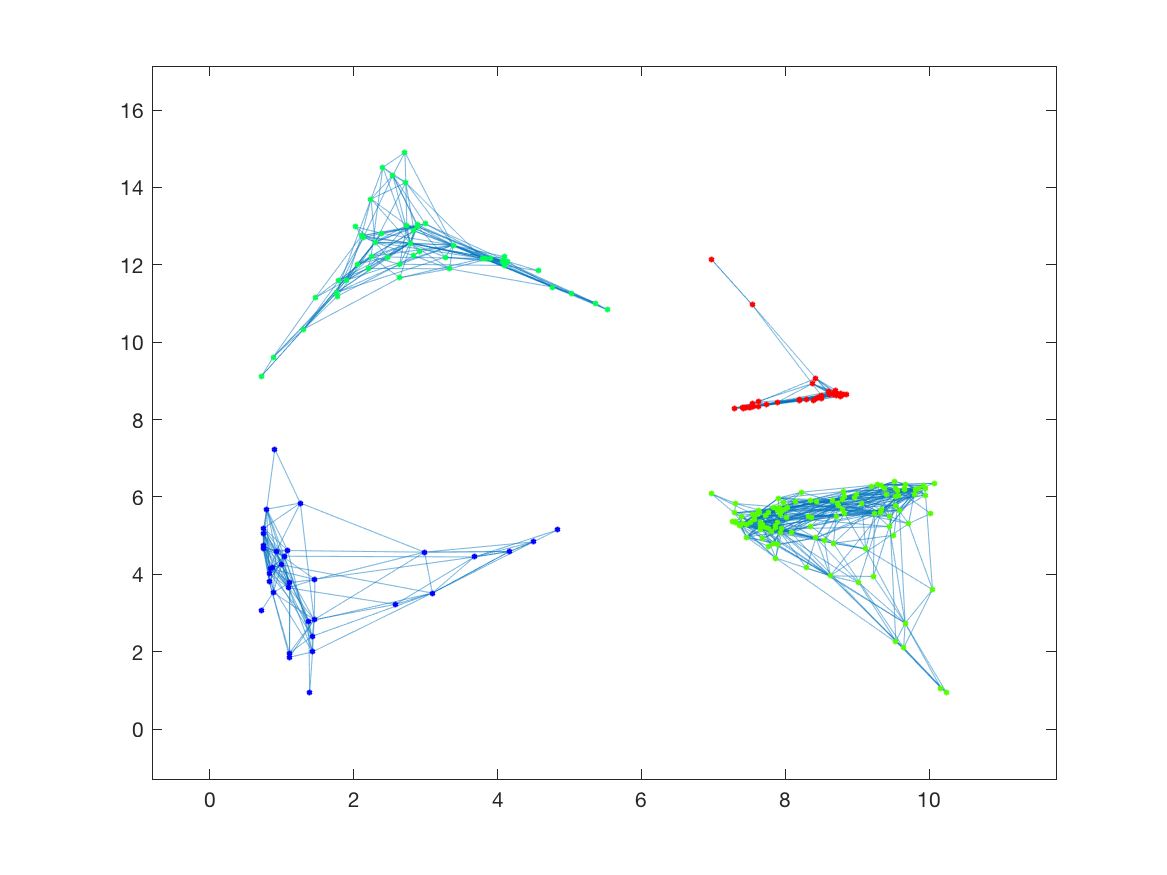

In [9]:
G.Nodes.clusterColor = cell2mat(arrayfun(@(x) ColorCodes(x, :), G.Nodes.cluster, 'UniformOutput', false));

imatlab_export_fig('print-png')
plot(G, 'NodeColor', G.Nodes.clusterColor)

## Discussion

Why just not apply $k$-means directly to the data? The following plot shows the performance of this solution with respect to the spectral graph clustering approach, where we can clearly observe misclassifications of points within the cluster:

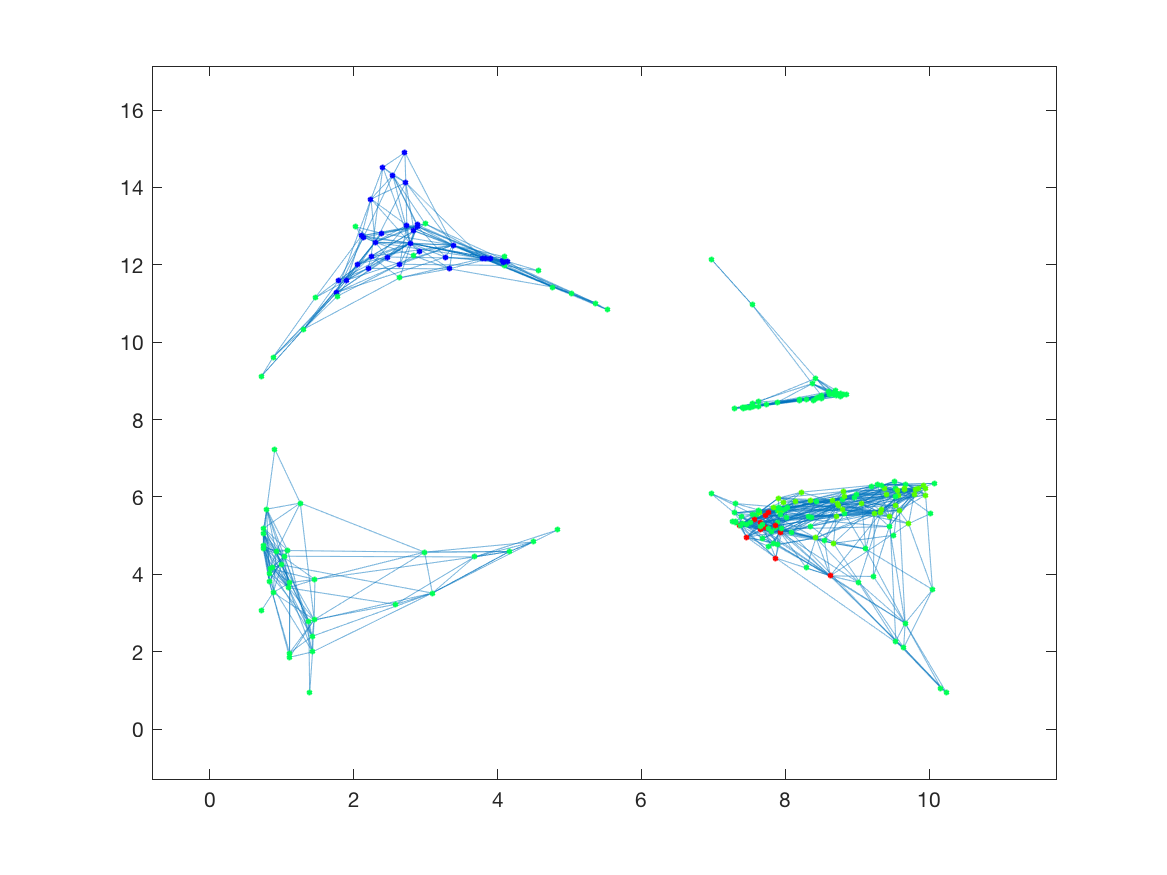

In [10]:
idxMeans = kmeans(A, k, 'MaxIter', maxIter);
GMeans = graph(full(As));
GMeans.Nodes.cluster = idxMeans;

GMeans.Nodes.clusterColor = cell2mat(arrayfun(@(x) ColorCodes(x, :), GMeans.Nodes.cluster, 'UniformOutput', false));

imatlab_export_fig('print-png')
plot(GMeans, 'NodeColor', GMeans.Nodes.clusterColor)

# Dataset 2

The second dataset is a synthetic graph created for testing the algorithm. We just use the previous defined functions in order to plot the final result:

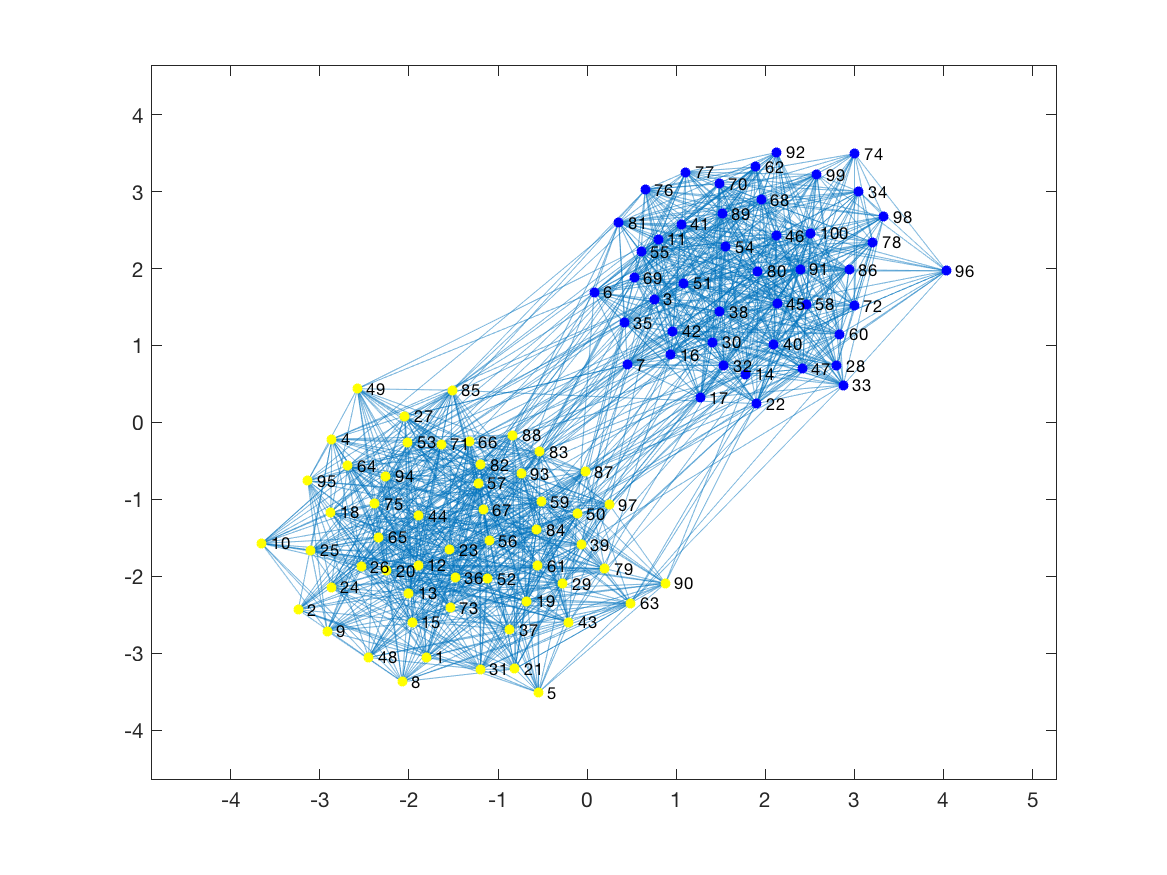

In [11]:
E2 = csvread('./data/example2.dat');
k2 = 2;
G2 = spectra(E2, k2);

% Plot final result
paletta2 = colorSpectrum(k2);
G2.Nodes.clusterColor = cell2mat(arrayfun(@(x) paletta2(x, :), G2.Nodes.cluster, 'UniformOutput', false));

imatlab_export_fig('print-png')
plot(G2, 'NodeColor', G2.Nodes.clusterColor)